<a href="https://colab.research.google.com/github/ipavlopoulos/revisiting-silhouette-aggregation/blob/main/revisiting_silhouette_aggregation_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Sihouette Coefficient
* Using micro and macro averaging.
* Using two sampling strategies, one per aggregation type.

In [117]:
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

import numpy as np
np.random.seed=42

def control_sample(X, clustering, balanced=False, sample_size=-1):
    """
    Sample data points from the dataset based on the specified strategy.

    This function samples data points based on the sample strategy:
    - 'uniform': Randomly samples 'sample_size' number of rows from the entire dataset.
    - 'balanced': Samples a specified number of rows per cluster.

    Parameters:
    X (array-like): 2D array-like structure with the coordinates of the data points.
    clustering (array-like): Cluster labels for the data points.
    balanced (bool): If True, samples a specified number of rows per cluster.
                     If False, samples 'sample_size' number of rows uniformly from the entire dataset.
    sample_size (int): Total number of samples to draw. If sample_size is less than 1, the entire dataset is returned.

    Returns:
    tuple: Two arrays, one with the sampled data points and another with the corresponding cluster labels.
    """
    if sample_size < 1:
        return X, clustering

    X = np.array(X)
    clustering = np.array(clustering)

    if not balanced:
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        return X[indices], clustering[indices]

    # Otherwise: sample n rows per cluster
    unique_clusters, counts = np.unique(clustering, return_counts=True)
    samples_per_cluster = max(1, sample_size // len(unique_clusters))

    sampled_X = []
    sampled_clustering = []

    for cluster in unique_clusters:
        cluster_indices = np.where(clustering == cluster)[0]
        sample_indices = np.random.choice(cluster_indices, size=min(len(cluster_indices), samples_per_cluster), replace=False)
        sampled_X.append(X[sample_indices])
        sampled_clustering.append(clustering[sample_indices])

    sampled_X = np.vstack(sampled_X)
    sampled_clustering = np.hstack(sampled_clustering)

    return sampled_X, sampled_clustering


class SampleSilhouette:

  def __init__(self, X, clustering, sample_size=-1, sample_strategy='micro'):
    self.X, self.clustering = control_sample(X, clustering, balanced=sample_strategy=='macro', sample_size=sample_size)
    self.point_sil = pd.DataFrame({'sil': silhouette_samples(self.X, self.clustering), 'label':self.clustering})


  def macro(self):
    """
    Macro-averaged silhouette, for per-cluster averaging, then returning their mean
    :return: the silhouette aggregated score
    """
    representatives = self.point_sil.groupby('label').sil.apply(np.mean)
    return representatives.mean()

  def micro(self):
    """
    Micro-averaged silhouette, as in sklearn
    :return: the silhouette aggregated score
    """
    return self.point_sil.sil.mean()

# Assessing KMeans using micro/macro-averaged Silhouette

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor):
    t = np.linspace(0, 4 * np.pi, n_clusters)
    x = t * np.cos(t)
    y = t * np.sin(t)

    X = []
    y_labels = []
    cluster_sizes = []
    for i in range(n_clusters):
        cx, cy = x[i], y[i]
        variance = base_variance
        # Number of points increasing with a growth factor
        points_per_cluster = int(base_points_per_cluster * np.exp(points_growth_factor * (n_clusters - i)))
        cluster_points = np.random.normal(loc=[cx, cy], scale=variance, size=(points_per_cluster, 2))
        X.append(cluster_points)
        y_labels.append(np.full(points_per_cluster, i))
        cluster_sizes.append(points_per_cluster)

    X = np.vstack(X)
    y_labels = np.hstack(y_labels)

    return X, y_labels, x, y, cluster_sizes

# Parameters for the dataset
n_clusters = 20
base_points_per_cluster = 10
base_variance = 0.1  # Same variance for all clusters

# Highest points growth factor to create the most imbalanced space
points_growth_factor = 0.3

# Generate the spiral clusters dataset
X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

# Run K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)
kmeans_labels = kmeans.labels_

# Compute the Silhouette Score
score = silhouette_score(X, kmeans_labels)
print(f'Silhouette Score for the most imbalanced space: {score}')

Silhouette Score for the most imbalanced space: 0.812348071798607


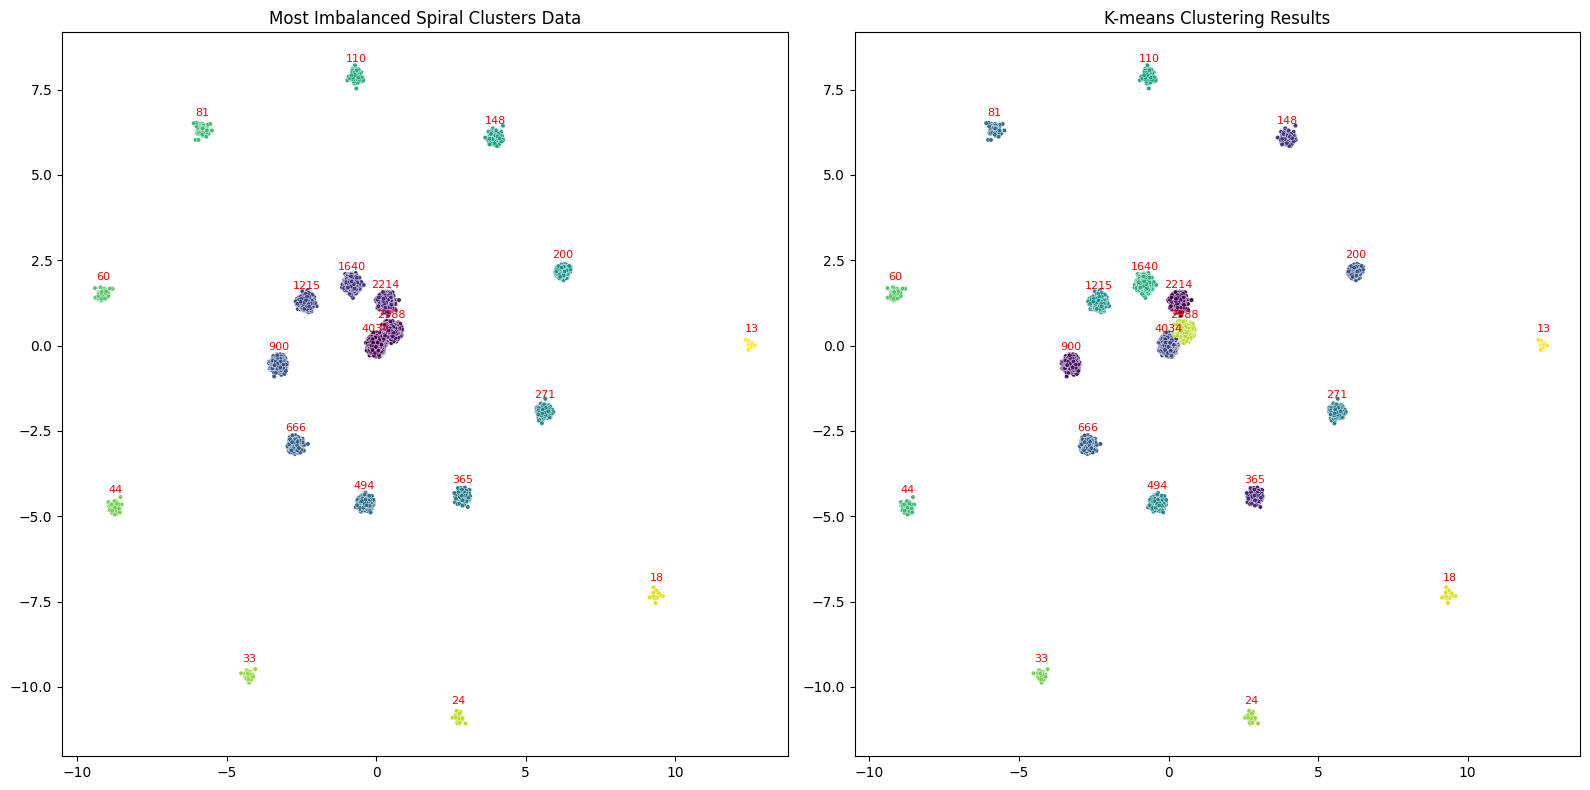

In [63]:
import seaborn as sns

# Plot the original dataset with true labels and annotations
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title("Most Imbalanced Spiral Clusters Data")
for i, (cx, cy) in enumerate(zip(x, y)):
    plt.annotate(str(cluster_sizes[i]), (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

# Plot the K-means clustering results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("K-means Clustering Results")
for i, (cx, cy) in enumerate(zip(x, y)):
    plt.annotate(str(cluster_sizes[i]), (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.tight_layout()
plt.show()

In [56]:
# Range of points growth factors to test
points_growth_factors = np.linspace(0.1, 0.3, 10)
macro_scores, micro_scores = [], []
for points_growth_factor in points_growth_factors:
    # Generate the spiral clusters dataset
    X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    ssilhouette = SampleSilhouette(X, kmeans_labels)
    macro_scores.append(ssilhouette.macro())
    micro_scores.append(ssilhouette.micro())

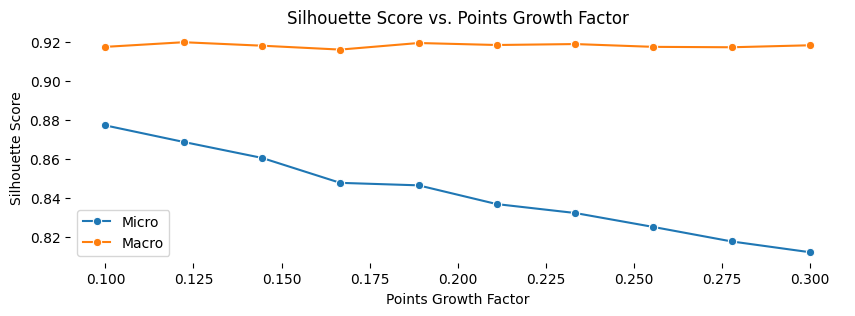

In [56]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=points_growth_factors, y=micro_scores, marker='o', label='Micro')
sns.lineplot(x=points_growth_factors, y=macro_scores, marker='o', label='Macro')
plt.legend()
plt.xlabel('Points Growth Factor')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Points Growth Factor')
sns.despine(left=True, bottom=True)

# Sampled and Averaged Silhouette

In [104]:
# Range of points growth factors to test
points_growth_factors = np.linspace(0.1, 0.3, 10)
macro_sils, micro_sils = [], []
for points_growth_factor in points_growth_factors:
    # Generate the spiral clusters dataset
    X, y_labels, x, y, cluster_sizes = generate_spiral_clusters_varying_points(n_clusters, base_points_per_cluster, base_variance, points_growth_factor)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    macro_sils.append(SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='macro'))
    micro_sils.append(SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='micro'))

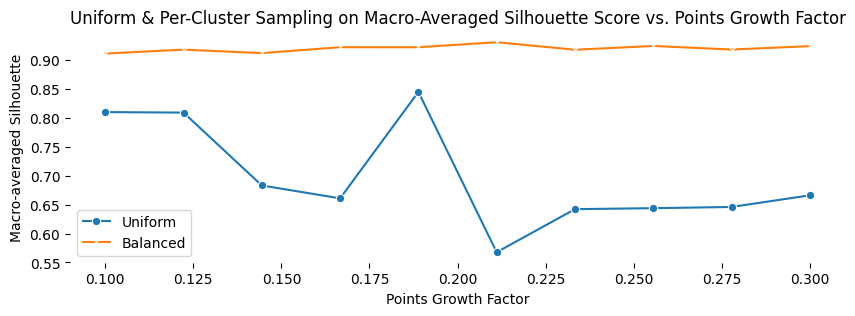

In [107]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=points_growth_factors, y=[s.macro() for s in micro_sils], marker='o', label='Uniform')
sns.lineplot(x=points_growth_factors, y=[s.macro() for s in macro_sils], marker='x', label='Balanced')
plt.legend()
plt.xlabel('Points Growth Factor')
plt.ylabel('Macro-averaged Silhouette')
plt.title('Uniform & Per-Cluster Sampling on Macro-Averaged Silhouette Score vs. Points Growth Factor')
sns.despine(left=True, bottom=True)

# Focusing on noise
* First, monitoring the macro and micro averaged Silhouette score as noise is added to a space of Gaussians.

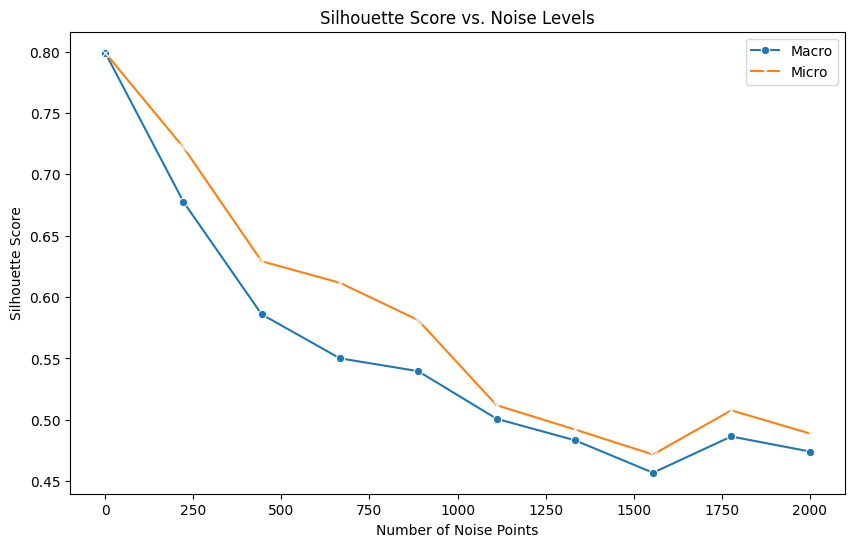

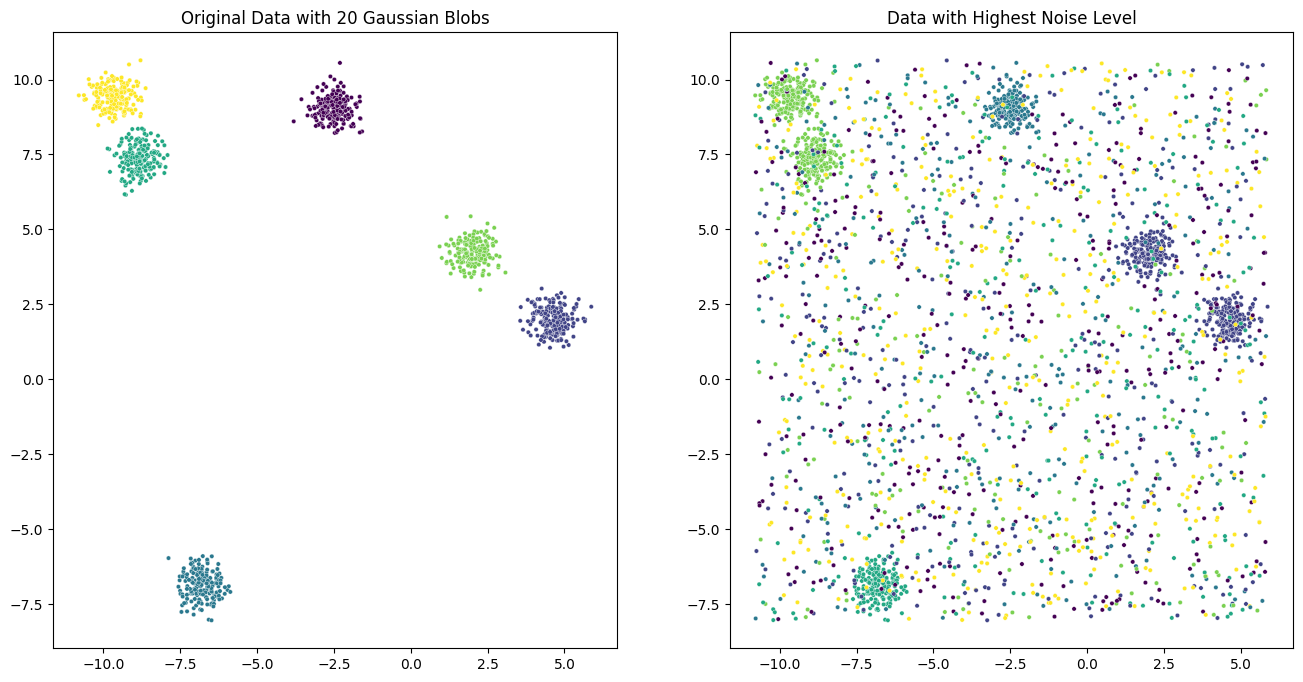

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def add_noise(X, n_noise_points):
    """
    Add random noise points to the dataset.

    Parameters:
    X (array-like): Original dataset.
    n_noise_points (int): Number of noise points to add.

    Returns:
    array-like: Dataset with added noise points.
    """
    noise = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(n_noise_points, 2))
    return np.vstack([X, noise])

# Generate the original dataset with 20 Gaussian blobs
n_clusters = 6
points_per_cluster = 200
X, y_labels = make_blobs(n_samples=n_clusters * points_per_cluster, centers=n_clusters, cluster_std=0.4, random_state=42)

# Range of noise levels to test
noise_levels = np.linspace(0, 2000, 10, dtype=int)
silhouette_scores_macro, silhouette_scores_micro = [], []

for n_noise_points in noise_levels:
    X_noisy = add_noise(X, n_noise_points)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_noisy)
    kmeans_labels = kmeans.labels_

    # Compute the Silhouette Score
    sil = SampleSilhouette(X_noisy, kmeans_labels)
    silhouette_scores_macro.append(sil.macro())
    silhouette_scores_micro.append(sil.micro())

# Plot the Silhouette Scores for different noise levels using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=noise_levels, y=silhouette_scores_macro, marker='o', label='Macro')
sns.lineplot(x=noise_levels, y=silhouette_scores_micro, marker='x', label='Micro')
plt.xlabel('Number of Noise Points')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Noise Levels')
plt.show()

# Plot the original dataset and one example with the highest noise level
plt.figure(figsize=(16, 8))

# Original dataset
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title("Original Data with 20 Gaussian Blobs")

# Dataset with the highest noise level
X_noisy = add_noise(X, noise_levels[-1])
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_noisy[:, 0], y=X_noisy[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("Data with Highest Noise Level")
plt.show()

* Now, the task changes to approximating the number of clusters, by varying K and computing Silhouette per noise level; per averaging strategy.

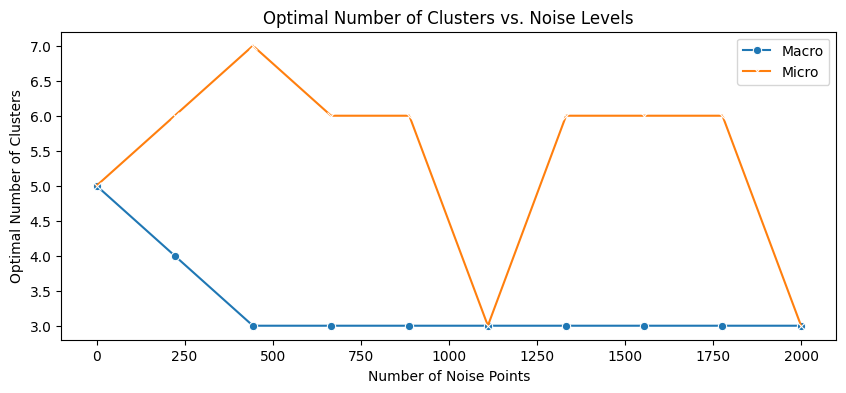

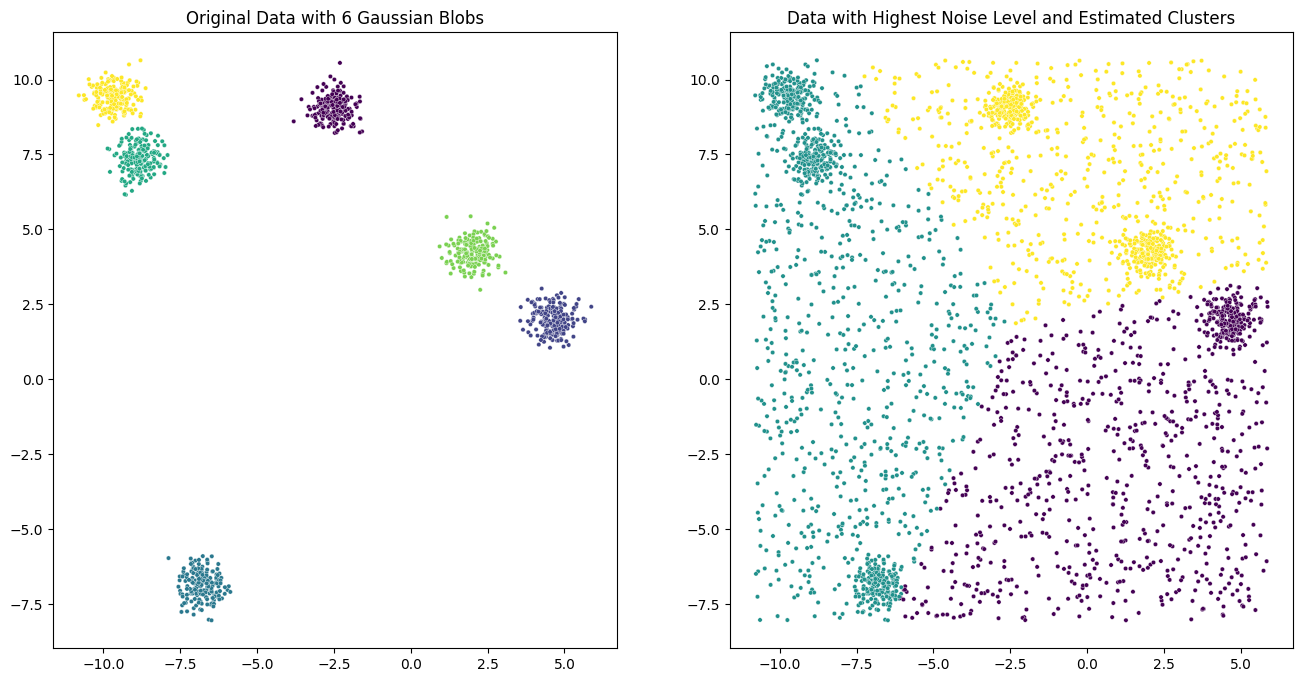

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of noise levels to test
noise_levels = np.linspace(0, 2000, 10, dtype=int)

# Range of number of clusters to test
cluster_range = range(3, 10)
optimal_clusters_per_noise_macro = []
optimal_clusters_per_noise_micro = []

for n_noise_points in noise_levels:
    X_noisy = add_noise(X, n_noise_points)

    best_score_micro, best_score_macro = -1, -1
    best_n_clusters_micro, best_n_clusters_macro = 0, 0
    for n_predicted_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_predicted_clusters, random_state=42, n_init='auto')
        kmeans.fit(X_noisy)
        kmeans_labels = kmeans.labels_
        ssil = SampleSilhouette(X_noisy, kmeans_labels)
        macrosil = ssil.macro()
        microsil = ssil.micro()

        if  macrosil > best_score_macro:
            best_score_macro = macrosil
            best_n_clusters_macro = n_predicted_clusters
        if  microsil > best_score_micro:
            best_score_micro = microsil
            best_n_clusters_micro = n_predicted_clusters

    optimal_clusters_per_noise_macro.append(best_n_clusters_macro)
    optimal_clusters_per_noise_micro.append(best_n_clusters_micro)

# Plot the number of clusters detected per noise level
plt.figure(figsize=(10, 4))
sns.lineplot(x=noise_levels, y=optimal_clusters_per_noise_macro, marker='o', label='Macro')
sns.lineplot(x=noise_levels, y=optimal_clusters_per_noise_micro, marker='x', label='Micro')
plt.xlabel('Number of Noise Points')
plt.ylabel('Optimal Number of Clusters')
plt.title('Optimal Number of Clusters vs. Noise Levels')
plt.show()

# Plot the original dataset and one example with the highest noise level
plt.figure(figsize=(16, 8))

# Original dataset
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title(f"Original Data with {n_clusters} Gaussian Blobs")

# Dataset with the highest noise level
X_noisy = add_noise(X, noise_levels[-1])
kmeans = KMeans(n_clusters=optimal_clusters_per_noise_micro[-1], random_state=42, n_init='auto')
kmeans.fit(X_noisy)
kmeans_labels = kmeans.labels_

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_noisy[:, 0], y=X_noisy[:, 1], hue=kmeans_labels, palette='viridis', s=10, legend=None)
plt.title("Data with Highest Noise Level and Estimated Clusters")
plt.show()

# Real-world datasets
* Loaded well-known real-world datasets of varying imbalance.
* Applied KMeans at the ground-truth number of clusters.
* Showing that Macro is positively correlated with external measures (NMI, AMI, ARI) while Micro is not.

In [166]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fetch datasets
def get_datasets():
    datasets_list = [
        ('Iris', load_iris(), 'Sepal and petal measurements of iris flowers.'),
        ('Wine', load_wine(), 'Chemical analysis of wines grown in the same region.'),
        ('Digits', load_digits(), 'Images of handwritten digits.'),
        ('Covertype', fetch_openml(name='covertype', version=1), 'Forest cover type from cartographic variables.'),
        ('Mice Protein', fetch_openml(name='MiceProtein', version=4), 'Protein expression levels in mice.'),
        ('Gas Sensor', fetch_openml(name='gas-drift', version=1), 'Gas sensor array drift dataset.'),
        ('Pendigits', fetch_openml(name='pendigits', version=1), 'Pen-based handwritten digits.'),
        ('Glass', fetch_openml(name='glass', version=1), 'Chemical compositions of glass samples.'),
        ('TCGA', fetch_openml(name='TCGA', version=1), 'Cancer genome atlas samples.')
    ]
    return datasets_list


# Function to preprocess datasets
def preprocess_dataset(data):
    if hasattr(data, 'data'):
        X = data.data
        y = data.target
    else:
        X = data.drop(columns='class')
        y = data['class']

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Dimensionality reduction (optional, here we keep the first 10 components for example)
    pca = PCA(n_components=min(10, X.shape[1]))
    X = pca.fit_transform(X)

    return X, y

# Fetch and preprocess datasets
datasets_list = get_datasets()

# Dictionary to store results
results = {
    'Number of Clusters': [],
    'Imbalance Ratio': [],
    'Dataset': [],
    'Micro Silhouette': [],
    'Macro Silhouette': [],
    'NMI':[],
    'AMI':[],
    'ARI':[]
}

# Measure imbalance ratio based on ground truth labels
for dataset_name, dataset in datasets_list:
    X, y = preprocess_dataset(dataset)
    unique, counts = np.unique(y, return_counts=True)
    imbalance_ratio = min(counts) / max(counts)

    n_clusters = len(unique)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_
    ssil = SampleSilhouette(X, kmeans_labels)
    macrosil = ssil.macro()
    microsil = ssil.micro()

    # external measures
    nmi = normalized_mutual_info_score(y, kmeans_labels)
    ari = adjusted_rand_score(y, kmeans_labels)
    ami = adjusted_mutual_info_score(y, kmeans_labels)


    # Store the results
    results['Dataset'].append(dataset_name)
    results['Number of Clusters'].append(n_clusters)
    results['Imbalance Ratio'].append(imbalance_ratio)
    results['Macro Silhouette'].append(macrosil)
    results['Micro Silhouette'].append(microsil)
    results['NMI'].append(nmi)
    results['ARI'].append(ari)
    results['AMI'].append(ami)


# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
latex_table = results_df.to_latex(index=False, column_format='|l|r|r|r|', header=True, float_format="%.2f")
print(latex_table)
# Display the results
print(results_df)

\begin{tabular}{|l|r|r|r|}
\toprule
Number of Clusters & Imbalance Ratio & Dataset & Micro Silhouette & Macro Silhouette & NMI & AMI & ARI \\
\midrule
3 & 1.00 & Iris & 0.46 & 0.46 & 0.66 & 0.66 & 0.62 \\
3 & 0.68 & Wine & 0.30 & 0.30 & 0.86 & 0.86 & 0.88 \\
10 & 0.95 & Digits & 0.27 & 0.26 & 0.63 & 0.63 & 0.50 \\
7 & 0.03 & Covertype & 0.18 & 0.18 & 0.10 & 0.10 & 0.05 \\
8 & 0.70 & Mice Protein & 0.17 & 0.21 & 0.25 & 0.24 & 0.13 \\
6 & 0.55 & Gas Sensor & 0.35 & 0.26 & 0.20 & 0.20 & 0.08 \\
10 & 0.92 & Pendigits & 0.29 & 0.29 & 0.66 & 0.66 & 0.51 \\
\bottomrule
\end{tabular}

   Number of Clusters  Imbalance Ratio       Dataset  Micro Silhouette  \
0                   3         1.000000          Iris          0.459948   
1                   3         0.676056          Wine          0.298139   
2                  10         0.950820        Digits          0.265148   
3                   7         0.025908     Covertype          0.176099   
4                   8         0.700000  Mice P

In [168]:
results_df[['Micro Silhouette', 'Macro Silhouette', 'NMI', 'AMI', 'ARI']].corr()

,Micro Silhouette,Macro Silhouette,NMI,AMI,ARI
Micro Silhouette,1.000000,0.914018,0.473178,0.474934,0.471074
Macro Silhouette,0.914018,1.000000,0.627838,0.627093,0.641853
NMI,0.473178,0.627838,1.000000,0.999942,0.981855
AMI,0.474934,0.627093,0.999942,1.000000,0.982142
ARI,0.471074,0.641853,0.981855,0.982142,1.000000


# Macro - Micro ~ $r$

* The absolute difference between macro and micro is negatively correlated with the balance ratio $r$.  
* The greater the distance of the two, the likelier it is that the clusters will be imbalanced.

In [7]:
import pandas as pd
df= pd.DataFrame()
df['macro']=[0.459029, 0.302968, 0.261517, 0.184873, 0.207891, 0.259013, 0.285636]
df['micro'] = [0.459948, 0.298139, 0.265148, 0.176099, 0.172442, 0.354146, 0.293603]
df['r'] = [1.000000, 0.676056, 0.950820, 0.025908, 0.700000, 0.545364, 0.922203]
df['mm'] = df.apply(lambda row: abs(row.macro-row.micro), 1)
df[['r','mm']].corr('spearman')

,r,mm
r,1.00,-0.75
mm,-0.75,1.00
